# Simple Hedging Example

This notebook works through all the steps of this hedging strategy applied to the S&P 500 index.

The strategy follows the steps below:

1. Use 3 month of historical data to estimate the parameters of the model via Baysian inference an probabilistic programming. Use this to estimate the future distribution at a later time time $T$ over the S&P 500 index.
2. Using teh estimate distribution, construct a portfolio of short/long put/call options to ensure a flat distribution over a fixed range of the expected distribution
3. Use the Kelly Criterion to determine the optimal amount of capital to allocate to the portfolio

### Some critical assumptions
We will assume that the evolution of the S&P 500 index over a short period of time obeys a geometric Brownian motion SDE with constant parameters
 $$d\log (S_t) = \left(\mu - \frac{\sigma^{2}}{2}\right)dt + \sigma dW_t$$

In [1]:
import numpy as np
import datetime as dt

from _fitting import *
from _utils import *

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 14


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/var/folders/k6/79gt8yds1l3gsjyykhx8fr4r0000gn/T/ipykernel_45686/2676093710.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
# Set ticker
ticker = "^GSPC"
option_ticker = "^SPX"

# set date range
ddays = 365
end_date = dt.datetime.today()
start_date = end_date - dt.timedelta(days=ddays)

# interval
interval = "1d"
dtime = int(interval[:-1])

# Get the data
data = get_stock_data(ticker, start_date, end_date, interval=interval)

# Compute log price and add days
data['log_close'] = np.log(data['Adj Close'])
data.index = data.index.date
data['days'] = (data.index - data.index[0]).days

#---------------------#
Getting underlying data for ticker:  ^GSPC
#---------------------#
[*********************100%***********************]  1 of 1 completed


In [3]:
# Get some rough estimates of mu and sigma
mu, sigma = estimate_coeffs(data['log_close'], len(data['log_close']), dtime)

print("mu: ", mu)
print("sigma: ", sigma)

mu:  -0.00017657803526675237
sigma:  0.014533240952140489


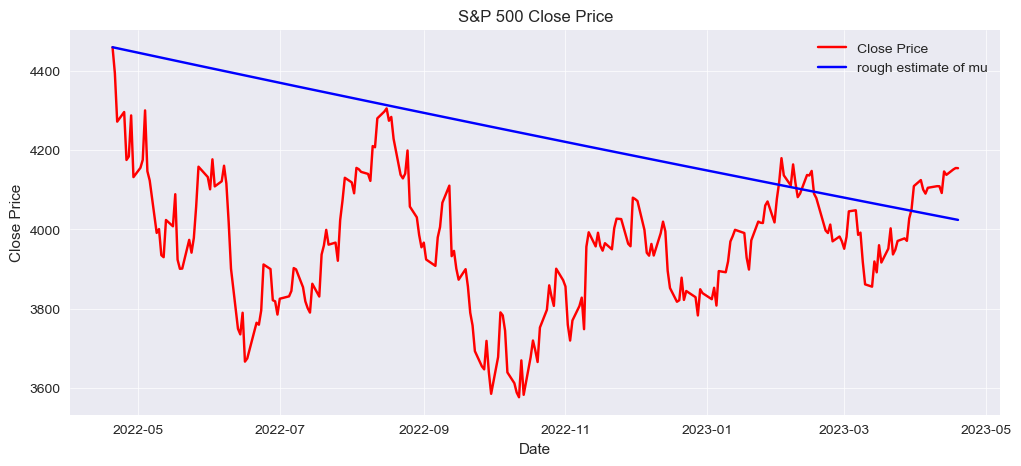

In [4]:
fig = plt.figure(figsize=(12, 5))
plt.plot(data.index, data["Close"], color='r', label="Close Price")

# Plot mu as a straight line with the date range
plt.plot(data.index, np.exp(data['log_close'][0] + (mu - 0.5* sigma**2) * data['days']), color='b', label="rough estimate of mu")

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("S&P 500 Close Price")
plt.grid(linestyle='-', linewidth=0.5)
plt.legend()

plt.show()

In [5]:
# We now fit the geometric brownian motion model to the data
trace = fit_geometric_brownian_motion(data['Close'].values, [mu, np.abs(mu), sigma], 1)

/Users/michael/miniconda3/lib/python3.10/site-packages/pymc/distributions/timeseries.py:973: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, stock]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


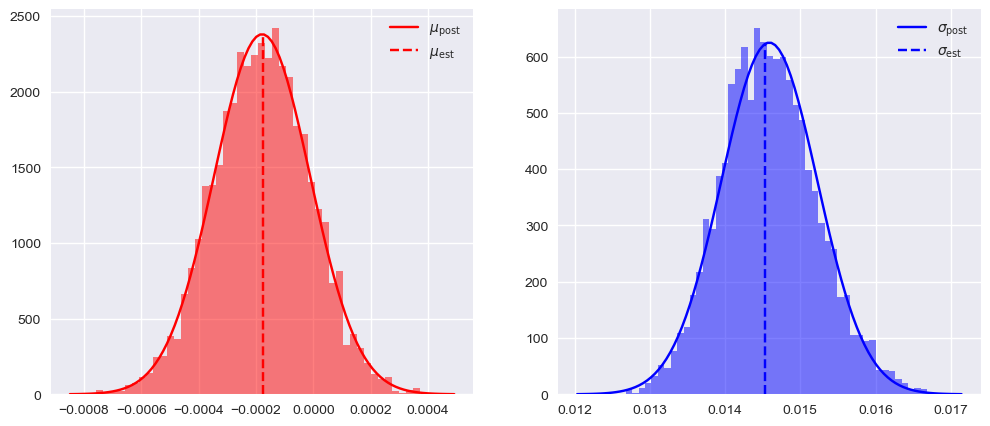

In [6]:
# Plot the trace estimates of the posterior distribution
mu_post = trace.posterior.get("mu").values.flatten()
sigma_post = trace.posterior.get("sigma").values.flatten()

# Get the pdfs of posterieor distributions
mu_pdf_x, mu_pdf = normal_pdf(mu_post)
sigma_pdf_x, sigma_pdf = normal_pdf(sigma_post)

fig = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mu_pdf_x, mu_pdf, color='r', label=r"$\mu_{\rm post}$")
plt.vlines(mu, 0, np.max(mu_pdf), color='r', linestyle='--', label=r"$\mu_{\rm est}$")
plt.hist(mu_post, bins=50, density=True, alpha=0.5, color='r')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sigma_pdf_x, sigma_pdf, color='b', label=r"$\sigma_{\rm post}$")
plt.vlines(sigma, 0, np.max(sigma_pdf), color='b', linestyle='--', label=r"$\sigma_{\rm est}$")
plt.hist(sigma_post, bins=50, density=True, alpha=0.5, color='b')
plt.legend()

plt.show()

In [7]:
# We can now infer the future probability distribution of the stock price using bayesian inference
# Future time we are inetrested in 
T = 7

s_range = [data['Close'].values[-1]*0.9, data['Close'].values[-1]*1.2]
s, s_est = infer_stock_pdf(mu_post, sigma_post, data['Close'].values[-1], T, s_range, ds=1)


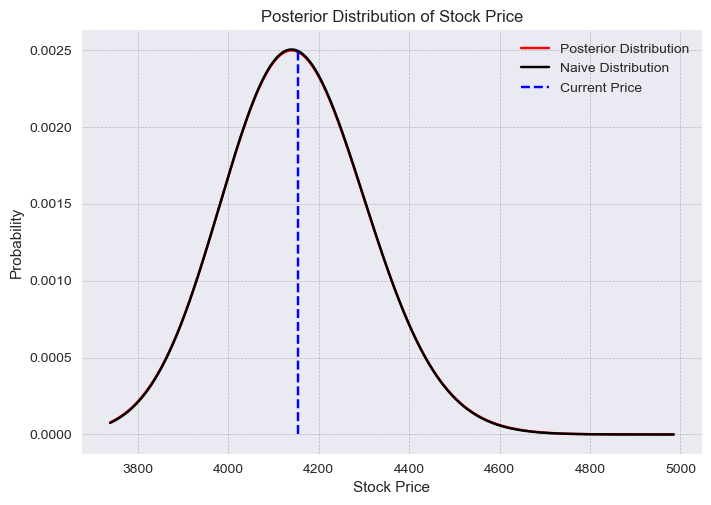

In [8]:
# Plot the posterior distribution
plt.plot(s, s_est, color='r', label="Posterior Distribution")
plt.plot(s, stock_pdf(s, data['Close'].values[-1], T, mu, sigma), color='k', label="Naive Distribution")
plt.vlines(data['Close'].values[-1], 0, np.max(s_est), color='b', linestyle='--', label="Current Price")

plt.xlabel("Stock Price")
plt.ylabel("Probability")
plt.title("Posterior Distribution of Stock Price")
plt.grid(linestyle='--', linewidth=0.5, color='grey', alpha=0.5)
plt.legend()

plt.show()

# Options Pricing 

Now we want to value particular European options for different strike prices at a particular time $T$. As a first implementation, we will use the Black-Scholes formula to value the options. This is a closed form solution to the SDE above.
$$
C(T, K) = S_0 N(d_{+}) - K e^{-r\tau} N(d_{-})
$$
where $\tau = T - t$ is the time to maturity, $d_{\pm}$ are the standard normal cumulative distribution function evaluated at the given strike price $K$ and the current price $S_0$ of the underlying asset, given by 
$$
d_\pm = \frac{\log(S_0/K) + (r \pm \frac{\sigma^2}{2})(\tau)}{\sigma \sqrt{\tau}}
$$
and finally $N$ is the standard normal cumulative distribution function
$$
N(y) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^y e^{-\frac{t^2}{2}} dt
$$

In [35]:
S0 = data['Close'].values[-1]
K = np.linspace(0.9*S0, 1.5*S0, 100)
tau = 60
today = data.index[-1]
expiry = today + dt.timedelta(days=tau)
sigma = np.mean(sigma_post)
r = get_repo_rate(today-dt.timedelta(days=1), today).values[0,0]/365

call_price = OptionsPriceBSM(S0, K, tau, sigma, r, option_type='call')
put_price = OptionsPriceBSM(S0, K, tau, sigma, r, option_type='put')

# Get the real options data from yahoo finance
call_options = OptionsData(option_ticker, expiry ,'put').get_options_data()

#---------------------#
Closest expirey date to 2023-06-18 is 2023-06-16
Using expirey date: 2023-06-16
#---------------------#


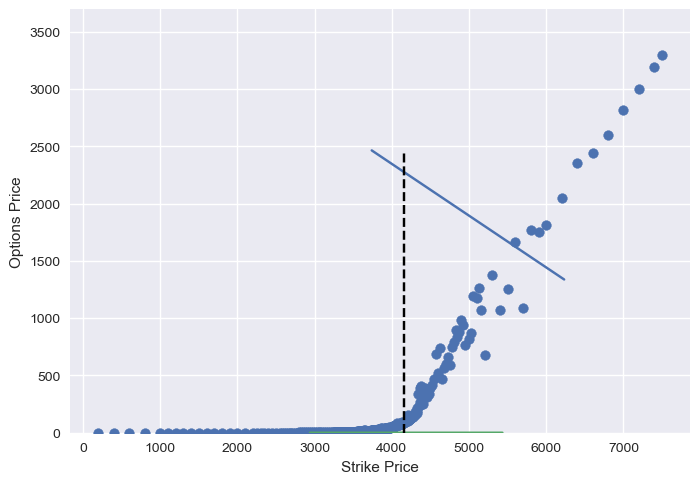

In [36]:
plt.plot(K, call_price, label="Call Price")
plt.plot(K-800, put_price, label="Put Price")

plt.vlines(S0, 0, np.max(call_price), color='k', linestyle='--', label="Current Price")

plt.scatter(call_options.index, call_options['lastPrice'], label="Call Options Price")
plt.xlabel("Strike Price")
plt.ylabel("Options Price")

# plt.xlim([0.8*S0, 1.1*S0])
plt.ylim([0, 1.5*np.max(call_price)])

plt.show()

In [23]:
# convert expiration and last trade date to datetime

K

array([3739.06801758, 3749.55922975, 3760.05044192, 3770.54165409,
       3781.03286626, 3791.52407843, 3802.0152906 , 3812.50650277,
       3822.99771494, 3833.48892711, 3843.98013928, 3854.47135145,
       3864.96256362, 3875.4537758 , 3885.94498797, 3896.43620014,
       3906.92741231, 3917.41862448, 3927.90983665, 3938.40104882,
       3948.89226099, 3959.38347316, 3969.87468533, 3980.3658975 ,
       3990.85710967, 4001.34832184, 4011.83953401, 4022.33074618,
       4032.82195835, 4043.31317052, 4053.80438269, 4064.29559486,
       4074.78680704, 4085.27801921, 4095.76923138, 4106.26044355,
       4116.75165572, 4127.24286789, 4137.73408006, 4148.22529223,
       4158.7165044 , 4169.20771657, 4179.69892874, 4190.19014091,
       4200.68135308, 4211.17256525, 4221.66377742, 4232.15498959,
       4242.64620176, 4253.13741393, 4263.6286261 , 4274.11983828,
       4284.61105045, 4295.10226262, 4305.59347479, 4316.08468696,
       4326.57589913, 4337.0671113 , 4347.55832347, 4358.04953

In [12]:
call_options = OptionsData(option_ticker, today ,'call').get_options_data()

#---------------------#
Closest expirey date to 2023-04-19 is 2023-04-20
Using expirey date: 2023-04-20
#---------------------#


In [20]:
call_options.index

Float64Index([3350.0, 3450.0, 3600.0, 3650.0, 3750.0, 3850.0, 3870.0, 3875.0,
              3900.0, 3920.0, 3925.0, 3935.0, 3940.0, 3950.0, 3960.0, 3965.0,
              3970.0, 3975.0, 3980.0, 3985.0, 3990.0, 3995.0, 4000.0, 4005.0,
              4010.0, 4015.0, 4020.0, 4025.0, 4030.0, 4035.0, 4040.0, 4045.0,
              4050.0, 4055.0, 4060.0, 4065.0, 4070.0, 4075.0, 4080.0, 4085.0,
              4090.0, 4095.0, 4100.0, 4105.0, 4110.0, 4115.0, 4120.0, 4125.0,
              4130.0, 4135.0, 4140.0, 4145.0, 4150.0, 4155.0, 4160.0, 4165.0,
              4170.0, 4175.0, 4180.0, 4185.0, 4190.0, 4195.0, 4200.0, 4205.0,
              4210.0, 4215.0, 4220.0, 4225.0, 4230.0, 4240.0, 4250.0, 4260.0,
              4270.0, 4275.0, 4300.0, 4350.0, 4400.0, 4500.0, 4600.0, 4800.0],
             dtype='float64', name='Strike')

In [22]:
K - S0

array([-415.45200195, -404.96078978, -394.46957761, -383.97836544,
       -373.48715327, -362.9959411 , -352.50472893, -342.01351676,
       -331.52230459, -321.03109242, -310.53988025, -300.04866808,
       -289.55745591, -279.06624374, -268.57503157, -258.0838194 ,
       -247.59260722, -237.10139505, -226.61018288, -216.11897071,
       -205.62775854, -195.13654637, -184.6453342 , -174.15412203,
       -163.66290986, -153.17169769, -142.68048552, -132.18927335,
       -121.69806118, -111.20684901, -100.71563684,  -90.22442467,
        -79.7332125 ,  -69.24200033,  -58.75078815,  -48.25957598,
        -37.76836381,  -27.27715164,  -16.78593947,   -6.2947273 ,
          4.19648487,   14.68769704,   25.17890921,   35.67012138,
         46.16133355,   56.65254572,   67.14375789,   77.63497006,
         88.12618223,   98.6173944 ,  109.10860657,  119.59981874,
        130.09103091,  140.58224309,  151.07345526,  161.56466743,
        172.0558796 ,  182.54709177,  193.03830394,  203.52951